In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
"""The Data is taken from the following repository"""
!git clone https://github.com/liulingbo918/ATFM.git

Cloning into 'ATFM'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 20.94 MiB | 7.63 MiB/s, done.


In [3]:
"""The data consists of 3 components: in/outflow and Holidays and weather data"""
!ls ./ATFM/data/TaxiNYC/

Holiday.txt  Meteorology.h5  NYC2014.h5  README.md


In [4]:
"""Some functions here are imported and modified
from: https://github.com/Mouradost/ASTIR"""

import h5py

def read_h5(filename):
    data = {}
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())
        # Get the data
        for key in a_group_key:
            data[key] = list(f[key])
    return data


def load_holiday(timeslots):
    fname='./ATFM/data/TaxiNYC/Holiday.txt'
    f = open(fname, 'r')
    holidays = f.readlines()
    holidays = set([h.strip() for h in holidays])
    H = np.zeros(len(timeslots))
    for i, slot in enumerate(timeslots):
        slot = str(slot)
        if slot[:8] in holidays:
            H[i] = 1
    return H[:, None]


def load_meteorol(timeslots):
    fname = "./ATFM/data/TaxiNYC/Meteorology.h5"
    data  = read_h5(fname)
    Timeslot = np.array(data['date'])
    WindSpeed = np.array(data['WindSpeed'])
    Weather = np.array(data['Weather'])
    Temperature = np.array(data['Temperature'])

    M = dict() 
    for i, slot in enumerate(Timeslot):
        slot = int(slot)
        M[slot] = i

    """make weather, windspeed and tempreature arrays
       based on the time slots"""
    WS = []  # WindSpeed
    WR = []  # Weather
    TE = []  # Temperature
    
    for slot in timeslots:
        slot = int(slot)
        predicted_id = M[slot]
        cur_id = predicted_id - 1
        WS.append(WindSpeed[cur_id])
        WR.append(Weather[cur_id])
        TE.append(Temperature[cur_id])

    WS = np.asarray(WS)
    WR = np.asarray(WR)
    TE = np.asarray(TE)

    #standardize
    WS = (WS - WS.min()) / (WS.max() - WS.min())
    TE = (TE - TE.min()) / (TE.max() - TE.min())
    merge_data = np.hstack([WR, WS[:, None], TE[:, None]])
    return merge_data


def buid_x_y(data, timestamps ,x_len, y_len):
    x = []
    y = []
    ts = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len, length):
        xtime = data[end_idx-y_len-x_len:end_idx-y_len]
        ytime = data[end_idx-y_len:end_idx]
        t = timestamps[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
        ts.append(t)
    x = np.stack(x)
    y = np.stack(y)
    ts = np.stack(ts)
    return x, y, ts
    

def load_data(T=48, x_len=9, len_test=4032):
    
    # read fow data
    fname = "./ATFM/data/TaxiNYC/NYC2014.h5"
    data  = read_h5(fname)
    timestamps = np.array(data['date'])
    data = np.array(data['data'])
    
    # Min max standardize
    minimum = data.min()
    maximum = data.max()
    data = (data - minimum) / (maximum - minimum)
    
    y_len = 1  # next step
    X, Y, timestamps_Y = buid_x_y(data, timestamps ,x_len, y_len)
    print('time features created')

    ext_feature = []
    
    # load holiday
    holiday_feature = load_holiday(timestamps_Y)
    ext_feature.append(holiday_feature)
    print('holiday features created')
    
    # load meteorol data
    meteorol_feature = load_meteorol(timestamps_Y)
    ext_feature.append(meteorol_feature)
    print('met features created')
    
    if len(ext_feature) > 0:
        ext_feature = np.hstack(ext_feature)
    else:
        ext_feature = np.asarray(ext_feature) 
    
    print('holiday feature:', holiday_feature.shape)
    print('meteorol feature: ', meteorol_feature.shape)
    print('ext feature: ', ext_feature.shape)

    X_train_ = X[:-1*len_test] 
    Y_train = Y[:-1*len_test]
    
    X_test_ = X[-1*len_test:]
    Y_test = Y[-1*len_test:]

    X_train = []
    X_test = []
    X_train.append(X_train_)
    X_test.append(X_test_)

    ext_feature_train, ext_feature_test = ext_feature[:-len_test], ext_feature[-len_test:]
    X_train.append(ext_feature_train)
    X_test.append(ext_feature_test)
    
    return X_train, Y_train, X_test, Y_test, minimum, maximum
        

def string2timestamp(strings, T=48):
    timestamps = []
    time_per_slot = 24.0 / T
    num_per_T = T // 24
    for t in strings:
        year, month, day, slot = int(t[:4]), int(t[4:6]), int(t[6:8]), int(t[8:])-1
        timestamps.append(pd.Timestamp(
            datetime(year, month, day, hour=int(slot * time_per_slot), 
                     minute=(slot % num_per_T) * int(60.0 * time_per_slot))))
    return timestamps

In [80]:
import time
import pandas as pd
from datetime import datetime

X_train, Y_train, X_test, Y_test, minimum, maximum = load_data(x_len=10)

"""build validation data from train data"""
X_train = [X_train[0][:-960], X_train[1][:-960]]
Y_train = Y_train[:-960]
X_val = [X_train[0][-960:], X_train[1][-960:]]
Y_val = Y_train[-960:]

print('Train Data')
print('time features: ', X_train[0].shape)
print('external: ',X_train[1].shape)
print('ext dim: ',X_train[1].shape[1])
print('labels: ',Y_train.shape)

print('Val Data')
print('time features: ', X_val[0].shape)
print('external: ',X_val[1].shape)
print('ext dim: ',X_val[1].shape[1])
print('labels: ',Y_val.shape)

time features created
holiday features created
met features created
holiday feature: (17509, 1)
meteorol feature:  (17509, 19)
ext feature:  (17509, 20)
Train Data
time features:  (12517, 10, 2, 15, 5)
external:  (12517, 20)
ext dim:  20
labels:  (12517, 1, 2, 15, 5)
Val Data
time features:  (960, 10, 2, 15, 5)
external:  (960, 20)
ext dim:  20
labels:  (960, 1, 2, 15, 5)


In [81]:
"""Build data loaders with batch size"""

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


ex_X_train = torch.Tensor(X_train[1]).to(device)
X_train = torch.Tensor(X_train[0]).to(device)
ex_X_val = torch.Tensor(X_val[1]).to(device)
X_val = torch.Tensor(X_val[0]).to(device)
ex_X_test = torch.Tensor(X_test[1]).to(device)
X_test = torch.Tensor(X_test[0]).to(device)
Y_train = torch.Tensor(Y_train).to(device)
Y_val = torch.Tensor(Y_val).to(device)
Y_test = torch.Tensor(Y_test).to(device)

Y_val = torch.squeeze(Y_val)
Y_train = torch.squeeze(Y_train)
Y_test = torch.squeeze(Y_test)

batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train, ex_X_train , Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
val_data = torch.utils.data.TensorDataset(X_val, ex_X_val , Y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(X_test, ex_X_test , Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [73]:
"""
This architecture is very similar to the ST-Resnet but here we 
use attention function to capture (weighting) long term 
dependencies instead of feature fusion

Ref: https://github.com/BruceBinBoxing/ST-ResNet-Pytorch
"""
import torch.nn as nn
from collections import OrderedDict

def conv_2d(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                         stride=stride, padding=1, bias= True)

class _bn_relu_conv(nn.Module):
    def __init__(self, nb_filter, bn = False):
        super(_bn_relu_conv, self).__init__()
        self.has_bn = bn
        self.relu = torch.relu
        self.conv1 = conv_2d(nb_filter, nb_filter)
    
    def forward(self, x):
        x = self.relu(x)
        x = self.conv1(x)
        return x

    
class _residual_unit(nn.Module):
    def __init__(self, nb_filter, bn=False):
        super(_residual_unit, self).__init__()
        self.bn_relu_conv1 = _bn_relu_conv(nb_filter, bn)
        self.bn_relu_conv2 = _bn_relu_conv(nb_filter, bn)

    def forward(self, x):
        residual = x
        out = self.bn_relu_conv1(x)
        out = self.bn_relu_conv2(out)
        out += residual
        return out

class ResUnits(nn.Module):
    def __init__(self, residual_unit, nb_filter, repetations=1):
        super(ResUnits, self).__init__()
        self.stacked_resunits = self.make_stack_resunits(residual_unit, nb_filter, repetations)

    def make_stack_resunits(self, residual_unit, nb_filter, repetations):
        layers = []
        for i in range(repetations):
            layers.append(residual_unit(nb_filter))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stacked_resunits(x)
        return x

class AttentionMLP(nn.Module):
    """
    MLP to weight the features according to its 
    importance to the forcasting
    """
    
    def __init__(self, t, n, h, w):
        super(AttentionMLP, self).__init__()
        self.weights = nn.Parameter(torch.randn(1, t * n, h, w),
                                    requires_grad = True)

    def forward(self, x):
        x = x * self.weights 
        return x

    
class AttResnet(nn.Module):
    def __init__(self, X, external_dim = 20, nb_residual_unit=3):
        super(AttResnet, self).__init__()
        self.external_dim = external_dim
        self.nb_residual_unit = nb_residual_unit
        self.time_steps, self.nb_flow, self.map_height, self.map_width = X[0], X[1], X[2], X[3]
        self.relu = torch.relu
        self.tanh = torch.tanh
        self.att_func = self.att(in_channels = self.time_steps * self.nb_flow)
        
        """
        using a linear relu combination to embed the external features
        according before addition to the weighted features
        """
        self.external_ops = nn.Sequential(
                nn.Linear(self.external_dim, 10, bias = True),
                nn.ReLU(),
                nn.Linear(10, self.nb_flow * self.map_height * self.map_width, bias = True),
                nn.ReLU()
            )
    
    def att(self, in_channels):
        return nn.Sequential(
            conv_2d(in_channels = in_channels, out_channels = 64),
            ResUnits(_residual_unit, nb_filter = 64, repetations = self.nb_residual_unit),
            nn.ReLU(),
            conv_2d(in_channels = 64, out_channels = self.time_steps * self.nb_flow),
            AttentionMLP(t=self.time_steps, n = self.nb_flow, h = self.map_height, w = self.map_width)
        )

    def forward(self, input_temp, input_ext):
        input_temp = input_temp.view(-1, self.time_steps * self.nb_flow, 
                                     self.map_height, self.map_width)
        out_temp = self.att_func(input_temp)
        out_temp = out_temp.view(-1, self.time_steps,  self.nb_flow, 
                                     self.map_height, self.map_width)
        out_temp = torch.mean(out_temp, dim = 1)
        out_temp = out_temp.view(-1, self.nb_flow, self.map_height, 
                                 self.map_width)
        ext_output = self.external_ops(input_ext)
        ext_output = self.relu(ext_output)
        ext_output = ext_output.view(-1, self.nb_flow, self.map_height, self.map_width)
        main_output = out_temp + ext_output
        main_output = self.tanh(main_output)
        return main_output

In [91]:
"""Build the model"""
X_shape = (10, 2, 15, 5)
attresnet = AttResnet(X_shape, external_dim=20, nb_residual_unit=4)
attresnet.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(attresnet.parameters(), lr=0.001)

In [68]:
"""validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for X_temporal, X_ext, Y in val_iter:
            outputs = model(X_temporal, X_ext)
            loss = loss_fn(outputs.cpu(), Y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss

In [92]:
"""training loop"""
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    losses = []
    for X_temporal, X_ext, Y in train_iter:
        outputs = attresnet(X_temporal, X_ext)
        loss = loss_fn(outputs, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    if epoch % 5 == 0:
        train_loss = np.mean(losses)
        val_loss = validate(attresnet)
        print('Epoch: ', epoch+1, 
              ', Train Loss: ', train_loss, 
              ', Val Loss: ', val_loss)

Epoch:  1 , Train Loss:  0.0014653843798590302 , Val Loss:  0.0002942635
Epoch:  6 , Train Loss:  0.00017142756797158877 , Val Loss:  0.00015244917
Epoch:  11 , Train Loss:  0.00015154509656542582 , Val Loss:  0.00010392272
Epoch:  16 , Train Loss:  0.0001289281995477908 , Val Loss:  9.513929e-05
Epoch:  21 , Train Loss:  0.00011074207785506067 , Val Loss:  0.00010304274
Epoch:  26 , Train Loss:  0.00011840036650399419 , Val Loss:  8.352799e-05
Epoch:  31 , Train Loss:  0.00010178822247660125 , Val Loss:  8.16256e-05
Epoch:  36 , Train Loss:  9.768653235740352e-05 , Val Loss:  7.708387e-05
Epoch:  41 , Train Loss:  9.456610912041339e-05 , Val Loss:  7.6103126e-05
Epoch:  46 , Train Loss:  8.855896427047235e-05 , Val Loss:  8.4710184e-05
Epoch:  51 , Train Loss:  9.238634981315676e-05 , Val Loss:  8.535786e-05
Epoch:  56 , Train Loss:  8.482232191899853e-05 , Val Loss:  7.869381e-05
Epoch:  61 , Train Loss:  8.369160309948896e-05 , Val Loss:  7.601696e-05
Epoch:  66 , Train Loss:  8.126

In [93]:
"""testing loop"""
attresnet.eval()
y_preds = list()
y_true = list()

with torch.no_grad():
    for X_temporal, X_ext, y in test_iter:
        y = y.cpu().numpy().reshape(-1)
        y_pred = attresnet(X_temporal, X_ext).view(len(y), -1).cpu().numpy().reshape(-1)
        y *= maximum
        y_pred *= maximum
        y_preds.extend(list(y_pred))
        y_true.extend(list(y))
        
y_preds = np.array(y_preds)
y_true = np.array(y_true)

In [94]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def smape(true, preds):
    mape = np.abs(preds - true) / (np.abs(true) + np.abs(preds))
    return 100/len(true) * np.sum(2 * mape)

print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))
print('sMAPE: ', smape(y_true.flatten(), y_preds.flatten()), "%")

RMSE:  20.357407
MAE:  11.170909
sMAPE:  42.79441809275794 %


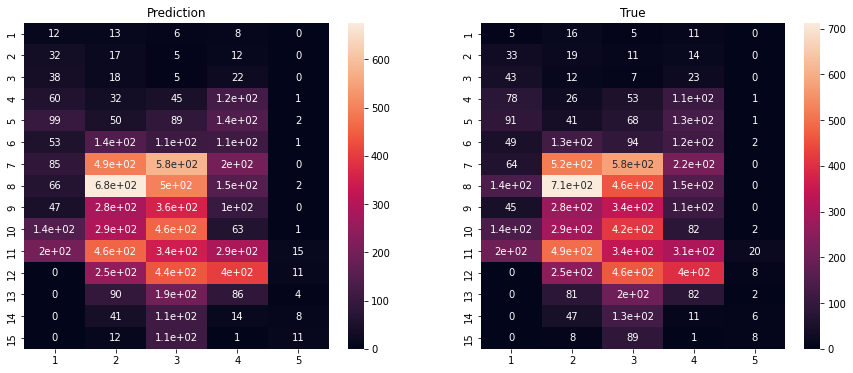

In [96]:
"""Prediction of inflow at certain time slice"""

import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow_true = y_true.reshape(4032, 2, 15, 5)[0, 0, :, :]
one_time_slice_inflow_preds = y_preds.reshape(4032, 2, 15, 5)[0, 0, :, :]
one_time_slice_inflow_preds = one_time_slice_inflow_preds.astype(int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

y_axis_labels = range(1,16)
x_axis_labels = range(1,6)

sns.heatmap(one_time_slice_inflow_preds, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax1, annot=True)

sns.heatmap(one_time_slice_inflow_true, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax2, annot=True)

ax2.set_title('True')
ax1.set_title('Prediction')
plt.show()

# References

- https://github.com/BruceBinBoxing/ST-ResNet-Pytorch

- https://github.com/Mouradost/ASTIR

- Junbo Zhang, Yu Zheng, Dekang Qi, Deep Spatio-Temporal Residual Networks for Citywide Crowd Flows Prediction, 2017
